In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS

from textblob import TextBlob

from tqdm import tqdm_notebook as tqdm
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

C:\Users\HP\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\HP\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict


In [2]:
df1 = pd.read_csv('ethiopia_tripadvisor_data_model_3.csv')
df1.head()

,Destination Name,Destination Type,Review Head,Review Body,Review Text,RB_Sentence1,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity Text,TextBlob Polarity RBS1,RB_Sentence1_Split
0,Rock-Hewn Churches of Lalibela,Landmarks,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...,Incredible locations don't be put off thinking...,Amazing location must visit.,-0.05,0.300000,0.125000,0.6000,"['Amazing', 'location', 'must', 'visit.']"
1,Rock-Hewn Churches of Lalibela,Landmarks,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...,It is a real miracle of the world! I do recomm...,I do recommend to visit Lalibela churches and ...,0.25,-0.150000,-0.016667,0.0000,"['I', 'do', 'recommend', 'to', 'visit', 'Lalib..."
2,Rock-Hewn Churches of Lalibela,Landmarks,Incredible experience,A must visit in Ethiopia - one of the most uni...,Incredible experience A must visit in Ethiopia...,A must visit in Ethiopia - one of the most uni...,0.90,0.345000,0.483750,0.4375,"['A', 'must', 'visit', 'in', 'Ethiopia', '-', ..."
3,Rock-Hewn Churches of Lalibela,Landmarks,Amazing,These churches have to be seen to be believed....,Amazing These churches have to be seen to be b...,These churches have to be seen to be believed.,0.60,0.225000,0.350000,0.0000,"['These', 'churches', 'have', 'to', 'be', 'see..."
4,Rock-Hewn Churches of Lalibela,Landmarks,So much history,Thanks to our tour organiser Ephram who is bas...,So much history Thanks to our tour organiser E...,Thanks to our tour organiser Ephram who is bas...,0.20,0.233333,0.228571,0.2000,"['Thanks', 'to', 'our', 'tour', 'organiser', '..."


In [3]:
df1['RH_Split'] = df1['Review Head'].apply(lambda x: x.split(' '))
df1['RB_Split'] = df1['Review Body'].apply(lambda x: x.split(' '))
df1['RT_Split'] = df1['Review Text'].apply(lambda x: x.split(' '))
df1['RB_Sentence1_Split'] = df1['RB_Sentence1'].apply(lambda x: x.split(' '))
df1.head()

,Destination Name,Destination Type,Review Head,Review Body,Review Text,RB_Sentence1,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity Text,TextBlob Polarity RBS1,RB_Sentence1_Split,RH_Split,RB_Split,RT_Split
0,Rock-Hewn Churches of Lalibela,Landmarks,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...,Incredible locations don't be put off thinking...,Amazing location must visit.,-0.05,0.300000,0.125000,0.6000,"[Amazing, location, must, visit.]","[Incredible, locations, don't, be, put, off, t...","[Amazing, location, must, visit., This, site, ...","[Incredible, locations, don't, be, put, off, t..."
1,Rock-Hewn Churches of Lalibela,Landmarks,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...,It is a real miracle of the world! I do recomm...,I do recommend to visit Lalibela churches and ...,0.25,-0.150000,-0.016667,0.0000,"[I, do, recommend, to, visit, Lalibela, church...","[It, is, a, real, miracle, of, the, world!]","[I, do, recommend, to, visit, Lalibela, church...","[It, is, a, real, miracle, of, the, world!, I,..."
2,Rock-Hewn Churches of Lalibela,Landmarks,Incredible experience,A must visit in Ethiopia - one of the most uni...,Incredible experience A must visit in Ethiopia...,A must visit in Ethiopia - one of the most uni...,0.90,0.345000,0.483750,0.4375,"[A, must, visit, in, Ethiopia, -, one, of, the...","[Incredible, experience, ]","[A, must, visit, in, Ethiopia, -, one, of, the...","[Incredible, experience, A, must, visit, in, E..."
3,Rock-Hewn Churches of Lalibela,Landmarks,Amazing,These churches have to be seen to be believed....,Amazing These churches have to be seen to be b...,These churches have to be seen to be believed.,0.60,0.225000,0.350000,0.0000,"[These, churches, have, to, be, seen, to, be, ...",[Amazing],"[These, churches, have, to, be, seen, to, be, ...","[Amazing, These, churches, have, to, be, seen,..."
4,Rock-Hewn Churches of Lalibela,Landmarks,So much history,Thanks to our tour organiser Ephram who is bas...,So much history Thanks to our tour organiser E...,Thanks to our tour organiser Ephram who is bas...,0.20,0.233333,0.228571,0.2000,"[Thanks, to, our, tour, organiser, Ephram, who...","[So, much, history]","[Thanks, to, our, tour, organiser, Ephram, who...","[So, much, history, Thanks, to, our, tour, org..."


In [4]:
df1['Destination Type'].value_counts()

Landmarks       3803
Museums         2507
Nature/Parks    2001
Name: Destination Type, dtype: int64

### Topic Modelling

In [5]:
# NLTK Stop words
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

test_subset = df1['RH_Split'].values
sid = SentimentIntensityAnalyzer()
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]

for value in test_subset:
    for word in value:
        if (sid.polarity_scores(word)['compound']) >= 0.4:
            pos_word_list.append(word)
        elif (sid.polarity_scores(word)['compound']) <= -0.4:
            print
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)                

print('Positive :', len(pos_word_list))       
print('Neutral :', len(neu_word_list))    
print('Negative :', len(neg_word_list))

Positive : 4118
Neutral : 35704
Negative : 326


In [6]:
from nltk.corpus import stopwords

main_stop_words = ['ethiopia', 'ethiopian', 'rock', 'hewn', 'church', 'churches', 'park', 'parks', 'museum', 
                       'museums', 'omo', 'valley', 'mountain', 'mountains', 'addis', 'ababa', 'lucy', 'simien', 
                       'national', 'lalibela', 'gelada', 'haile', 'selassie', 'gondar', 'africa' , 'harar', 
                       'cathedral', 'cathedrals', 'place', 'visit', 'girmay', 
                       '\n', '‘s']
positive_stop_words = list(set(pos_word_list))
negative_stop_words = list(set(neg_word_list))
total_stop_words = main_stop_words + positive_stop_words + negative_stop_words

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend(total_stop_words)
print('Stop Words: ', len(stop_words))

Stop Words:  862


In [7]:
# Convert to list
data = df1[df1['Destination Type'] == 'Museums'][df1['TextBlob Polarity Head'] > 0]['Review Head'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['For a quick hop only']


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['for', 'quick', 'hop', 'only']]


In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['for', 'quick', 'hop', 'only']


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['quick', 'hop']]


In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('hop', 1), ('quick', 1)]]

In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
# Print the Keyword in the n topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.063*"go" + 0.057*"little" + 0.052*"tour" + 0.050*"hour" + 0.040*"well" + '
  '0.037*"work" + 0.035*"item" + 0.033*"afternoon" + 0.030*"restaurant" + '
  '0.029*"food"'),
 (1,
  '0.070*"visit" + 0.060*"building" + 0.059*"evolution" + 0.051*"trip" + '
  '0.040*"make" + 0.028*"historic" + 0.022*"still" + 0.022*"sure" + '
  '0.018*"view" + 0.018*"entry"'),
 (2,
  '0.194*"first" + 0.107*"informative" + 0.063*"time" + 0.059*"cultural" + '
  '0.039*"historical" + 0.031*"basement" + 0.027*"local" + 0.020*"start" + '
  '0.019*"maintain" + 0.018*"diversity"'),
 (3,
  '0.260*"guide" + 0.067*"really" + 0.046*"photo" + 0.029*"expect" + '
  '0.025*"country" + 0.025*"ancient" + 0.024*"quite" + 0.024*"extremely" + '
  '0.020*"location" + 0.020*"top"'),
 (4,
  '0.439*"worth" + 0.048*"look" + 0.042*"stop" + 0.034*"section" + '
  '0.032*"simple" + 0.022*"short" + 0.014*"prehistoric" + 0.012*"explanation" '
  '+ 0.010*"tourist" + 0.010*"paleo"'),
 (5,
  '0.352*"important" + 0.030*"part" + 0.028*

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.826936518486144

Coherence Score:  0.6598411296848165


In [17]:
# # Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

In [18]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
os.environ.update({'MALLET_HOME':r'C:/Users/HP/mallet-2.0.8/'})
mallet_path = r'C:\Users\HP\mallet-2.0.8\bin\mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word, random_seed=1)

In [20]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('worth', 0.2634730538922156),
   ('exhibit', 0.1377245508982036),
   ('time', 0.10179640718562874),
   ('spend', 0.041916167664670656),
   ('hour', 0.03592814371257485),
   ('historic', 0.023952095808383235),
   ('life', 0.023952095808383235),
   ('guide', 0.017964071856287425),
   ('ancient', 0.017964071856287425),
   ('present', 0.017964071856287425)]),
 (1,
  [('human', 0.08433734939759036),
   ('make', 0.0783132530120482),
   ('building', 0.060240963855421686),
   ('full', 0.060240963855421686),
   ('trip', 0.04819277108433735),
   ('photo', 0.04819277108433735),
   ('presentation', 0.04216867469879518),
   ('cool', 0.03614457831325301),
   ('worthwhile', 0.030120481927710843),
   ('decent', 0.024096385542168676)]),
 (2,
  [('small', 0.23129251700680273),
   ('move', 0.17006802721088435),
   ('display', 0.08843537414965986),
   ('food', 0.047619047619047616),
   ('item', 0.047619047619047616),
   ('work', 0.04081632653061224),
   ('highly', 0.034013605442176874),
   ('qual

2
3
4
5
6
7
8
9
10


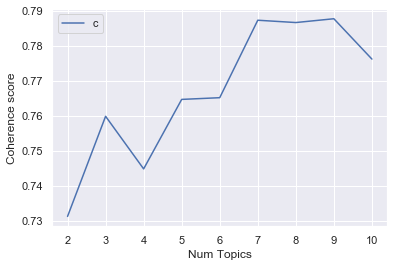

In [21]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word,
                                                random_seed=1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

start1 = 2 
limit1 = 11
step1 = 1

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start1, limit=limit1, step=step1)

x = range(start1, limit1, step1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.7313
Num Topics = 3  has Coherence Value of 0.7599
Num Topics = 4  has Coherence Value of 0.7448
Num Topics = 5  has Coherence Value of 0.7647
Num Topics = 6  has Coherence Value of 0.7652
Num Topics = 7  has Coherence Value of 0.7873
Num Topics = 8  has Coherence Value of 0.7866
Num Topics = 9  has Coherence Value of 0.7877
Num Topics = 10  has Coherence Value of 0.7762


In [23]:
optimal_model = model_list[7] # Number of Topics = 9

# optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.098*"time" + 0.052*"hour" + 0.040*"food" + 0.040*"highly" + 0.040*"spend" '
  '+ 0.034*"recommend" + 0.034*"work" + 0.034*"people" + 0.029*"start" + '
  '0.029*"meet"'),
 (1,
  '0.570*"worth" + 0.067*"stop" + 0.031*"guide" + 0.031*"recent" + '
  '0.016*"explanation" + 0.016*"trip" + 0.010*"description" + 0.010*"deal" + '
  '0.010*"lack" + 0.010*"end"'),
 (2,
  '0.128*"collection" + 0.110*"history" + 0.105*"visit" + 0.099*"display" + '
  '0.047*"local" + 0.047*"small" + 0.029*"content" + 0.023*"quality" + '
  '0.017*"give" + 0.017*"informative"'),
 (3,
  '0.197*"small" + 0.125*"experience" + 0.079*"photo" + 0.046*"quick" + '
  '0.046*"item" + 0.026*"bone" + 0.026*"ground" + 0.020*"watercolour" + '
  '0.020*"art" + 0.020*"extremely"'),
 (4,
  '0.176*"important" + 0.070*"make" + 0.053*"human" + 0.053*"lot" + '
  '0.053*"evolution" + 0.048*"find" + 0.037*"full" + 0.037*"afternoon" + '
  '0.032*"poorly" + 0.032*"floor"'),
 (5,
  '0.353*"history" + 0.043*"top" + 0.037*"insight" + 0

In [24]:
optimal_model2 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model2, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.262131 -0.175214       1        1  11.166304
4      0.137223 -0.177376       2        1  11.138700
7      0.050033  0.315200       3        1  11.129528
8      0.128773 -0.082021       4        1  11.125996
1      0.201083 -0.064229       5        1  11.121972
0      0.222277 -0.082225       6        1  11.115863
6     -0.196154 -0.027571       7        1  11.115399
2     -0.262102 -0.018769       8        1  11.069249
3     -0.019002  0.312205       9        1  11.016989, topic_info=    Category        Freq         Term       Total  loglift  logprob
3    Default  126.000000        worth  126.000000  30.0000  30.0000
30   Default  117.000000      history  117.000000  29.0000  29.0000
12   Default   38.000000    important   38.000000  28.0000  28.0000
7    Default   68.000000        small   68.000000  27.0000  27.0000
37   Default   49.000000  informative   49.000000  26.0000  26.0000
18   Default   28.000000         move   28.000000  25.0000  25.0000
29   Default   27.000000   collection   27.000000  24.0000  24.0000
17   Default   26.000000   experience   26.000000  23.0000  23.0000
34   Default   26.000000      exhibit   26.000000  22.0000  22.0000
33   Default   25.000000        visit   25.000000  21.0000  21.0000
203  Default   21.000000      display   21.000000  20.0000  20.0000
82   Default   21.000000         time   21.000000  19.0000  19.0000
95   Default   18.000000        learn   18.000000  18.0000  18.0000
43   Default   18.000000      culture   18.000000  17.0000  17.0000
55   Default   17.000000        photo   17.000000  16.0000  16.0000
41   Default   15.000000         make   15.000000  15.0000  15.0000
96   Default   14.000000        thing   14.000000  14.0000  14.0000
56   Default   14.000000         stop   14.000000  13.0000  13.0000
15   Default   12.000000         tour   12.000000  12.0000  12.0000
89   Default   16.000000        human   16.000000  11.0000  11.0000
81   Default   11.000000          lot   11.000000  10.0000  10.0000
87   Default   11.000000    evolution   11.000000   9.0000   9.0000
40   Default   11.000000     building   11.000000   8.0000   8.0000
83   Default   14.000000         hour   14.000000   7.0000   7.0000
204  Default   20.000000          art   20.000000   6.0000   6.0000
159  Default   10.000000         find   10.000000   5.0000   5.0000
234  Default   10.000000  information   10.000000   4.0000   4.0000
44   Default   10.000000        local   10.000000   3.0000   3.0000
305  Default    9.000000         item    9.000000   2.0000   2.0000
73   Default   11.000000   historical   11.000000   1.0000   1.0000
..       ...         ...          ...         ...      ...      ...
17    Topic9   26.964081   experience   26.964081   2.2057  -2.0794
375   Topic9    1.419162        sided    1.419162   2.2057  -5.0239
314   Topic9    1.419162       search    1.419162   2.2057  -5.0239
499   Topic9    1.419162     resource    1.419162   2.2057  -5.0239
435   Topic9    1.419162       plenty    1.419162   2.2057  -5.0239
494   Topic9    1.419162      setting    1.419162   2.2057  -5.0239
475   Topic9    1.419162      bizarre    1.419162   2.2057  -5.0239
470   Topic9    4.257486  watercolour    4.257486   2.2057  -3.9253
523   Topic9    2.838324   archeology    2.838324   2.2057  -4.3307
508   Topic9    2.838324     entrance    2.838324   2.2057  -4.3307
404   Topic9    1.419162      inflict    1.419162   2.2057  -5.0239
407   Topic9    1.419162         lose    1.419162   2.2057  -5.0239
416   Topic9    1.419162      drawing    1.419162   2.2057  -5.0239
418   Topic9    1.419162       modify    1.419162   2.2057  -5.0239
446   Topic9    1.419162      unusual    1.419162   2.2057  -5.0239
473   Topic9    1.419162      faclity    1.419162   2.2057  -5.0239
543   Topic9    1.419162         room    1.419162   2.2057  -5.0239
535   Topic9    1.419162       

In [25]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.1239,"culture, learn, history, tour, art, historical...",For a quick hop only
1,1,0.0,0.1111,"time, hour, food, highly, spend, recommend, wo...",Amazing
2,2,0.0,0.1111,"time, hour, food, highly, spend, recommend, wo...",Interesting
3,3,0.0,0.1111,"time, hour, food, highly, spend, recommend, wo...",great place to be
4,4,0.0,0.1111,"time, hour, food, highly, spend, recommend, wo...",Worthwhile visit
5,5,0.0,0.1111,"time, hour, food, highly, spend, recommend, wo...",Terribly touching
6,6,0.0,0.1111,"time, hour, food, highly, spend, recommend, wo...",Worth a visit
7,7,0.0,0.1111,"time, hour, food, highly, spend, recommend, wo...","Great Museum, good Memorial."
8,8,0.0,0.1111,"time, hour, food, highly, spend, recommend, wo...",Very touching
9,9,0.0,0.1111,"time, hour, food, highly, spend, recommend, wo...",A once great museum


In [27]:
df_dominant_topic['Dominant_Topic'].value_counts()

0.0    565
1.0    133
4.0     99
3.0     92
8.0     89
7.0     88
6.0     83
2.0     79
5.0     78
Name: Dominant_Topic, dtype: int64

In [38]:
df_dominant_topic.to_csv('ethiopia_452.csv', index = False)

In [40]:
# Run 2

# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # Topicless/Unidentifiable - 565
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # Topicless/Unidentifiable - 133
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # Interest on Exhibits - 79
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3]['Text'].values # Topicless/Unidentifiable - 92
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4]['Text'].values # History Appreciation - 99
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5]['Text'].values # History Appreciation - 78
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 6]['Text'].values # Interest on Exhibits - 83
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 7]['Text'].values # History Appreciation - 88
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 8]['Text'].values # Interest on Exhibits - 89

In [33]:
# Run 1

# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # General Appreciation - 556
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # General Appreciation - 71
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # History Appreciation - 86
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3]['Text'].values # Commending Fossils/Human Element - 77
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4]['Text'].values # General Appreciation - 115
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5]['Text'].values # Interest on Exhibits - 78
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 6]['Text'].values # History Appreciation - 71
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 7]['Text'].values # Commending Informativeness - 93
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 8]['Text'].values # General Appreciation - 83
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 9]['Text'].values # Interest on Exhibits - 76

In [44]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1686,"time, hour, food, highly, spend, recommend, wo...",First time in Jinka 1967-68.Worked with School...
1,1.0,0.1593,"worth, stop, guide, recent, explanation, trip,...","Lacking credibility, but worth a stop"
2,2.0,0.1432,"collection, history, visit, display, local, sm...","A must when visiting Addis Abeba, but very str..."
3,3.0,0.1453,"small, experience, photo, quick, item, bone, g...",A Museum That Really Needs To Charge More Entr...
4,4.0,0.1535,"important, make, human, lot, evolution, find, ...",Small but amazing finds to evidence human evol...
5,5.0,0.1453,"history, top, insight, exhibition, cultural, s...","Beautiful house, interesting exhibition"
6,6.0,0.1488,"culture, learn, history, tour, art, historical...",Great way to learn the history and culture of ...
7,7.0,0.1455,"move, small, information, modern, basement, ov...",Great section on lower floor with history of m...
8,8.0,0.1453,"informative, exhibit, thing, building, simple,...",Fantastic and informative living museum


In [45]:
sent_topics_sorteddf_mallet['Text'].values

array(['First time in Jinka 1967-68.Worked with School buildings. Bak Jan.2016.Met Nerere Dile who 67 was around 15 years .!!!!',
       'Lacking credibility, but worth a stop',
       'A must when visiting Addis Abeba, but very strong.',
       'A Museum That Really Needs To Charge More Entrance',
       'Small but amazing finds to evidence human evolution',
       'Beautiful house, interesting exhibition',
       'Great way to learn the history and culture of Ethiopia',
       'Great section on lower floor with history of mankind',
       'Fantastic and informative living museum'], dtype=object)

In [46]:
# # Number of Documents for Each Topic
# topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# # Percentage of Documents for Each Topic
# topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# # Topic Number and Keywords
# topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# # Concatenate Column wise
# df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# # Change Column names
# df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# # Show
# df_dominant_topics